In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="230"

In [2]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [3]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [4]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  c346d603-ce57-4ad4-abbb-d9522570a953  2017-12-09T22:24:41Z   
1  cd8efc5e-5f6f-44fc-a606-5122a438e2f5  2017-10-29T00:46:29Z   
2  9658b385-1d48-41c4-a372-2d5d2e632409  2018-01-06T20:48:33Z   
3  520bdd8e-6752-4bd4-9264-eadabbbe9104  2017-12-28T13:26:53Z   
4  a7de98ca-a710-4ead-b5cd-1226aa3b3501  2017-12-26T22:33:40Z   

                           request_id  partner_id origin destination  \
0  vpCIqIC3yyXwEnIhfjXdF02OddTUrIGYoZ         230    SCL         PTY   
1  eO5J9FGe5EHi7goH3JImYmOsS7qezoMA3S         230    GIG         PTY   
2  832fyYpXjKbVOuyEjMTXYniwirAJHA7VQC         230    SCL         PTY   
3  FWURXkdg9E83sMgpQKwXeqoGfDcXYS2FO5         230    MEX         PTY   
4  G1h1urs8TKxQLkCt9fvSB4ThyzpERk8Zf6         230    PTY         TPA   

   flight_number departure_date departure_time currency     ...      \
0            174     2017-12-30          03:12      USD     ...       
1            872     2017-12-18          02:30      USD     ...       
2            112     2018-02-09          05:58      USD     ...       
3            149     2017-12-30          14:30      USD     ...       
4            393     2018-01-15          09:20      USD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5      406      2991             mi       738          400.0   
1           5      436      3294             mi       738          520.0   
2           5      403      2991             mi       738          400.0   
3           5      231      1500             mi       738          290.0   
4           5      202      1324             mi       73G          270.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0          200.0            280.0          NaN         NaN  
1          320.0            345.0          NaN         NaN  
2          200.0            280.0          NaN         NaN  
3          140.0            160.0          NaN         NaN  
4          140.0            160.0          NaN         NaN  

[5 rows x 33 columns]

In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139454 entries, 0 to 139453
Data columns (total 33 columns):
event_id                              139454 non-null object
event_time                            139454 non-null object
request_id                            139454 non-null object
partner_id                            139454 non-null int64
origin                                139454 non-null object
destination                           139454 non-null object
flight_number                         139454 non-null int64
departure_date                        139454 non-null object
departure_time                        139454 non-null object
currency                              139454 non-null object
pnr                                   139454 non-null object
language                              139454 non-null object
pax                                   139454 non-null int64
eligibility                           139454 non-null bool
point_of_sale                         13

In [6]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [7]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
139449  2018-02-08T10:39:58Z         230    REC         PTY            166   
139450  2017-11-23T02:34:09Z         230    PTY         COR            101   
139451  2018-02-21T07:48:41Z         230    PTY         MBJ            146   
139452  2017-11-17T14:28:52Z         230    MVD         PTY            284   
139453  2017-10-24T14:26:59Z         230    MEX         PTY            149   

       departure_date departure_time currency language  pax   ...    \
139449     2018-02-09          01:19      USD       pt    1   ...     
139450     2017-11-24          15:56      USD       ES    3   ...     
139451     2018-02-28          09:03      USD       es    1   ...     
139452     2017-11-21          01:20      USD       ES    2   ...     
139453     2017-11-02          14:35      USD       en    1   ...     

        upgrade_type duration distance equipment slider_max_usd  \
139449      BUSINESS      441     3286       73G          410.0   
139450      BUSINESS      400     2969       73G          375.0   
139451      BUSINESS      123      660       E90          200.0   
139452      BUSINESS      448     3400       738          440.0   
139453      BUSINESS      226     1500       738          290.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
139449          210.0            275.0         230.0    4124043.0    True  
139450          175.0            200.0         214.0    3885226.0    True  
139451           48.0             58.0          64.2    4190895.0    True  
139452          240.0            270.0         258.0    3251724.0    True  
139453          140.0            160.0         145.6    3785741.0    True  

[5 rows x 26 columns]

In [8]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    139454.0  139454.000000  139454.000000  139454.000000  139454.000000   
mean        230.0     406.735217       1.722288     250.873119    1715.362464   
std           0.0     221.831651       1.270059     129.492274    1081.865767   
min         230.0      15.000000       1.000000      53.000000     199.000000   
25%         230.0     224.000000       1.000000     137.000000     780.000000   
50%         230.0     360.000000       1.000000     213.000000    1345.000000   
75%         230.0     555.000000       2.000000     391.000000    2969.000000   
max         230.0    4453.000000      55.000000     491.000000    3400.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   139454.000000   139454.000000     139454.000000  27891.000000   
mean       307.572461      152.562193        182.051408    195.716722   
std        106.587264       73.968351         76.056548     86.520898   
min        120.000000       19.000000         30.000000     21.400000   
25%        205.000000       80.000000        110.000000    128.400000   
50%        295.000000      145.000000        170.000000    200.000000   
75%        400.000000      200.000000        250.000000    251.450000   
max        575.000000      375.000000        400.000000    615.250000   

        customer_id  
count  2.789100e+04  
mean   3.848208e+06  
std    4.421540e+05  
min    1.776922e+06  
25%    3.768149e+06  
50%    3.932019e+06  
75%    4.110940e+06  
max    4.287867e+06

In [9]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 139454  139454      139454         139454   
unique                104383      75          75            454   
top     2018-01-31T15:21:50Z     PTY         PTY     2018-01-07   
freq                       6   70912       67403           1022   

       departure_time currency language point_of_sale channel_source  \
count          139454   139454   139454        139454         139454   
unique            733        1        7            34             21   
top             07:50      USD       es            GS   CHASER_EMAIL   
freq             1129   139454    76058         47957          46279   

       carrier_code fare_class from_cabin upgrade_type equipment  
count        139454     139454     139454       139454    139454  
unique            1         16          1            1         3  
top              CM          E    ECONOMY     BUSINESS       738  
freq         139454      45108     139454       139454     99736

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139454 entries, 0 to 139453
Data columns (total 26 columns):
event_time          139454 non-null object
partner_id          139454 non-null int64
origin              139454 non-null object
destination         139454 non-null object
flight_number       139454 non-null int64
departure_date      139454 non-null object
departure_time      139454 non-null object
currency            139454 non-null object
language            139454 non-null object
pax                 139454 non-null int64
eligibility         139454 non-null bool
point_of_sale       139454 non-null object
channel_source      139454 non-null object
carrier_code        139454 non-null object
fare_class          139454 non-null object
from_cabin          139454 non-null object
upgrade_type        139454 non-null object
duration            139454 non-null int64
distance            139454 non-null int64
equipment           139454 non-null object
slider_max_usd      139454 non-null 

In [11]:
#What is the distribution of has bid
sns.countplot(df.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


Has_bid percentage: 25.00%


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

In [12]:
plot_distribution( df , var = 'slider_start_usd' , target = 'has_bid' )

In [13]:
plot_distribution( df , var = 'slider_max_usd' , target = 'has_bid' )

In [14]:
plot_distribution( df , var = 'slider_min_usd' , target = 'has_bid' )

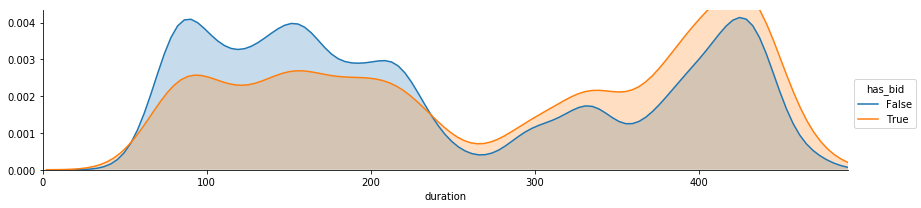

In [15]:
plot_distribution( df , var = 'duration' , target = 'has_bid' )

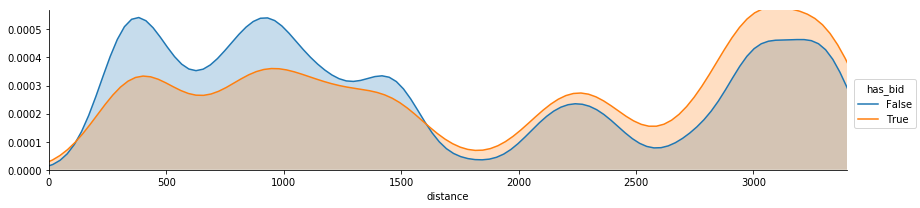

In [16]:
plot_distribution( df , var = 'distance' , target = 'has_bid' )

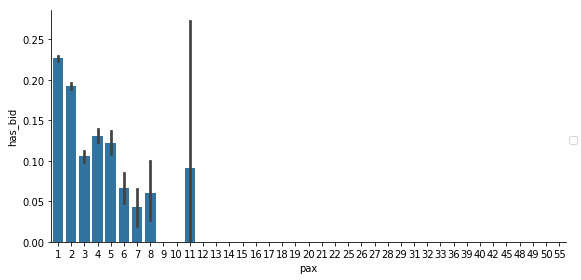

In [17]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

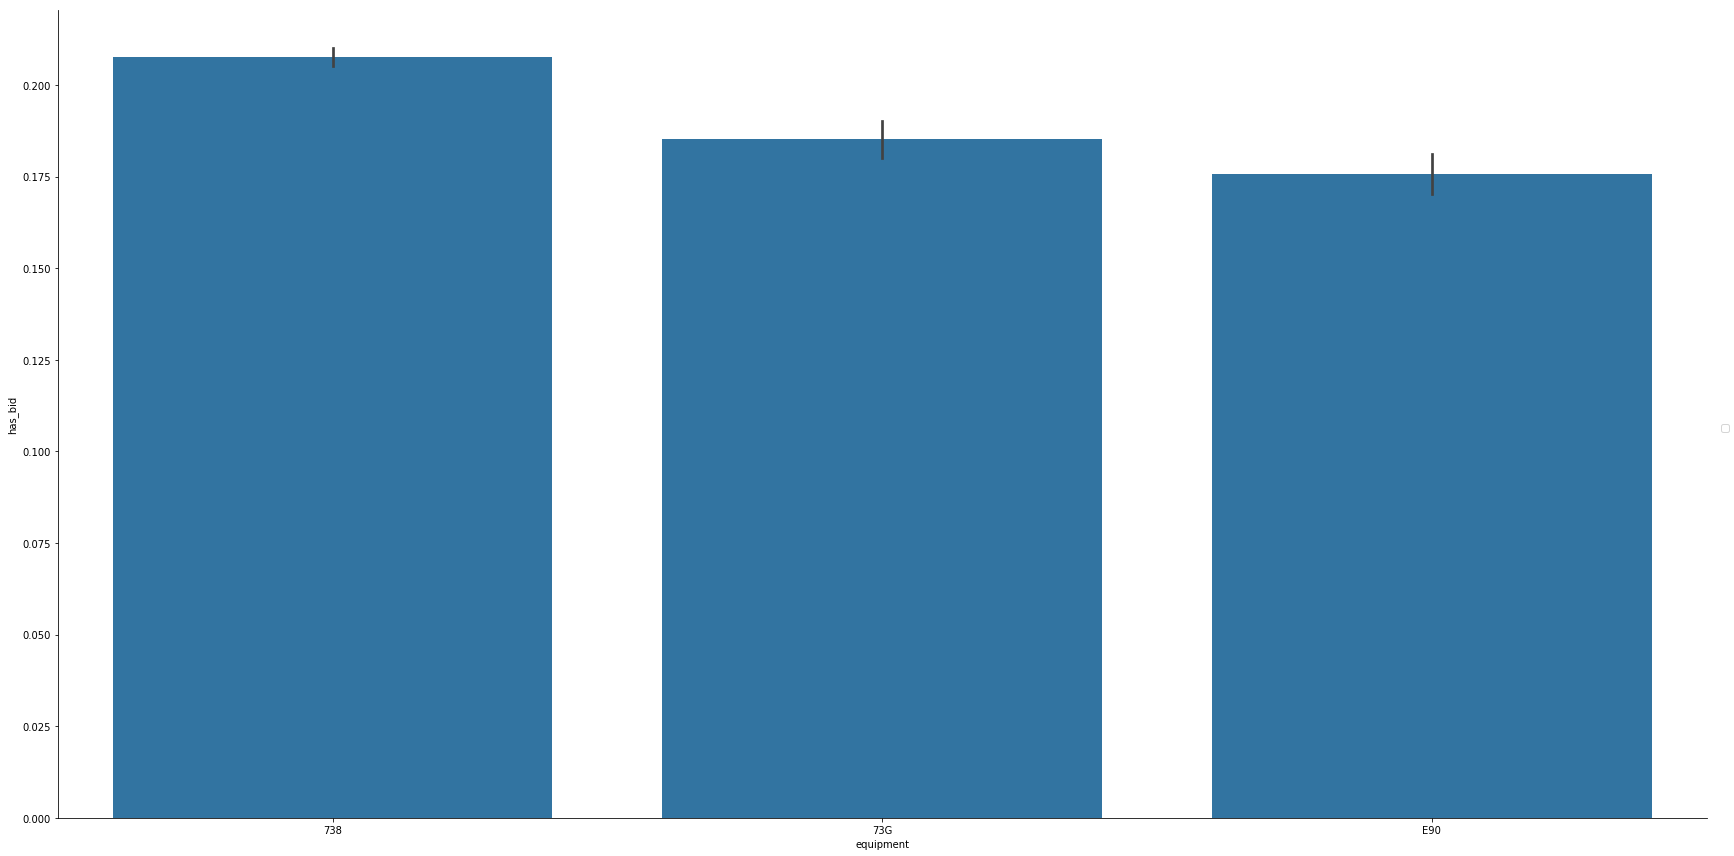

In [18]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

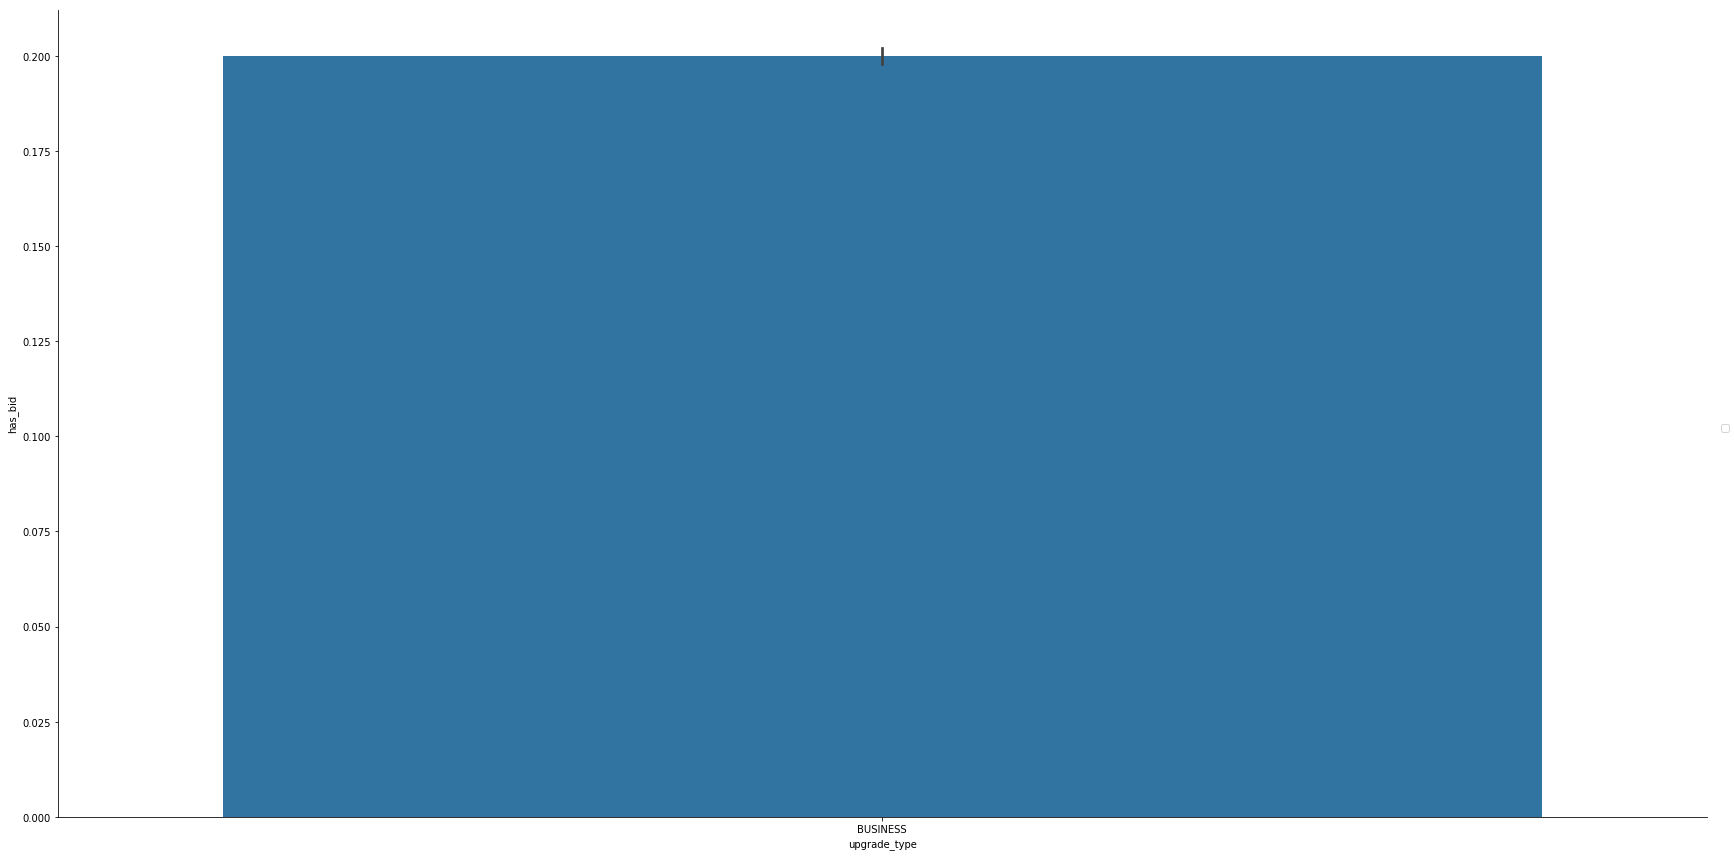

In [19]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

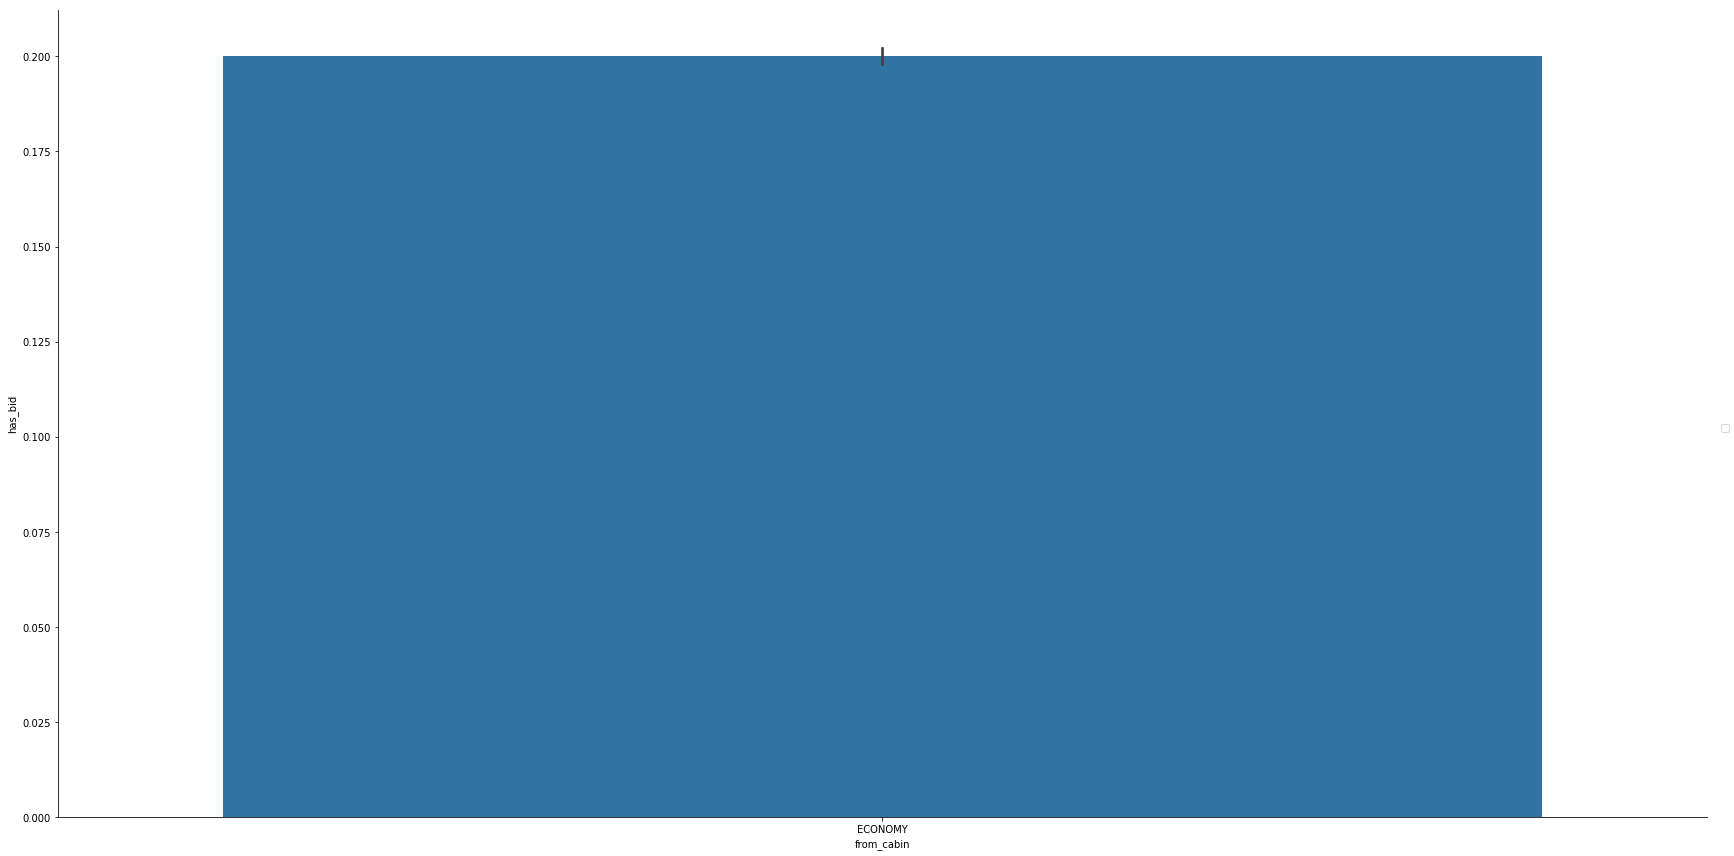

In [20]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

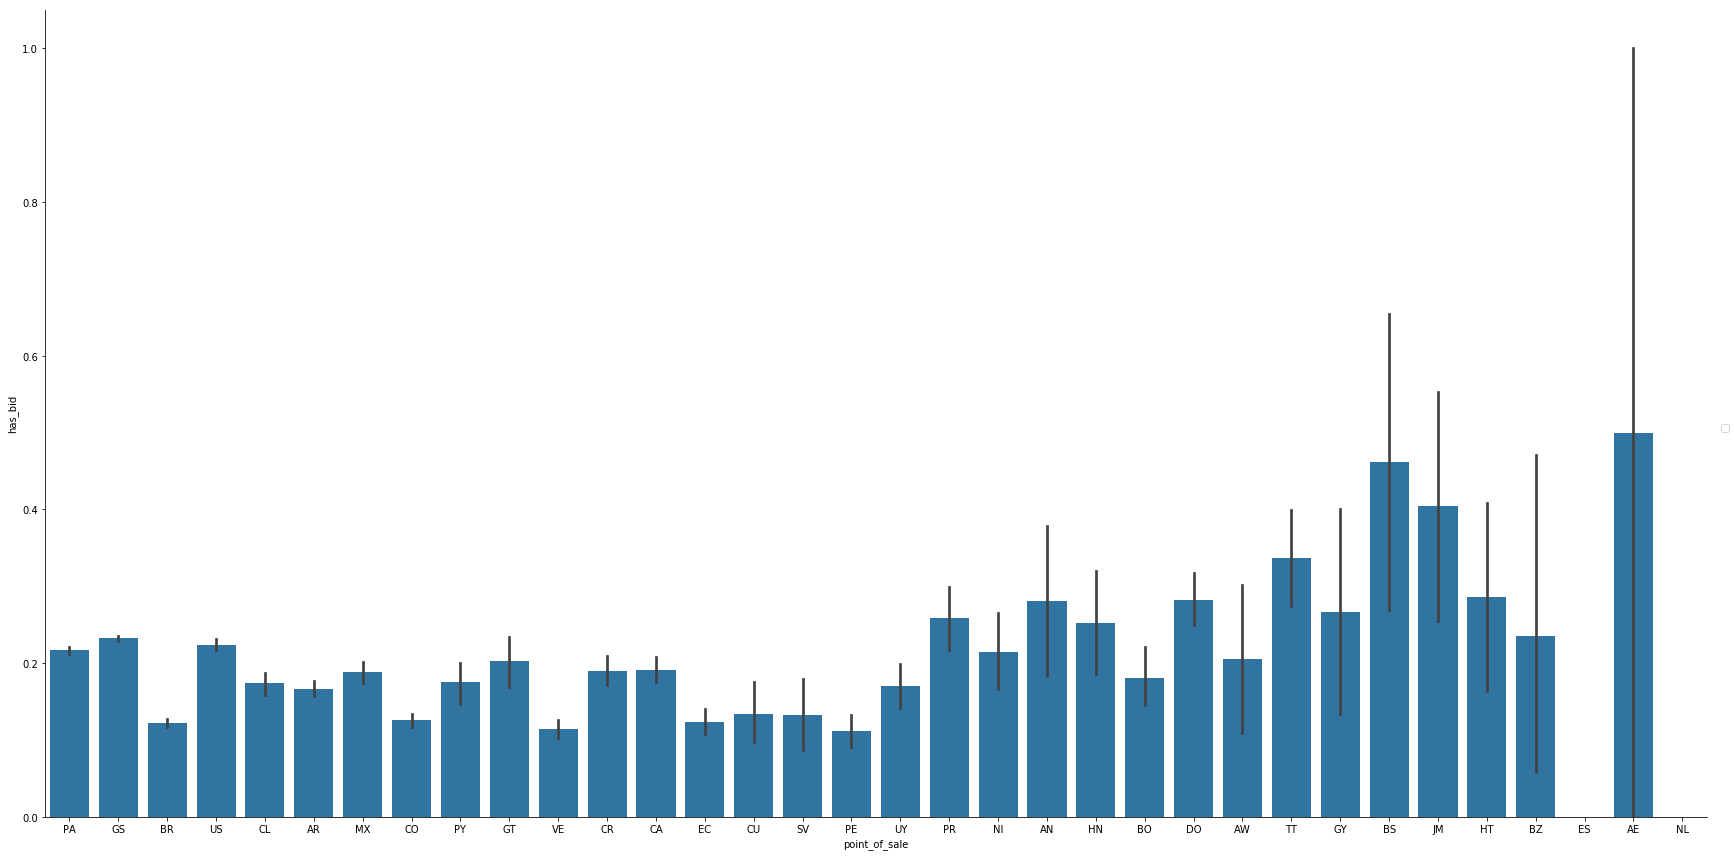

In [21]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

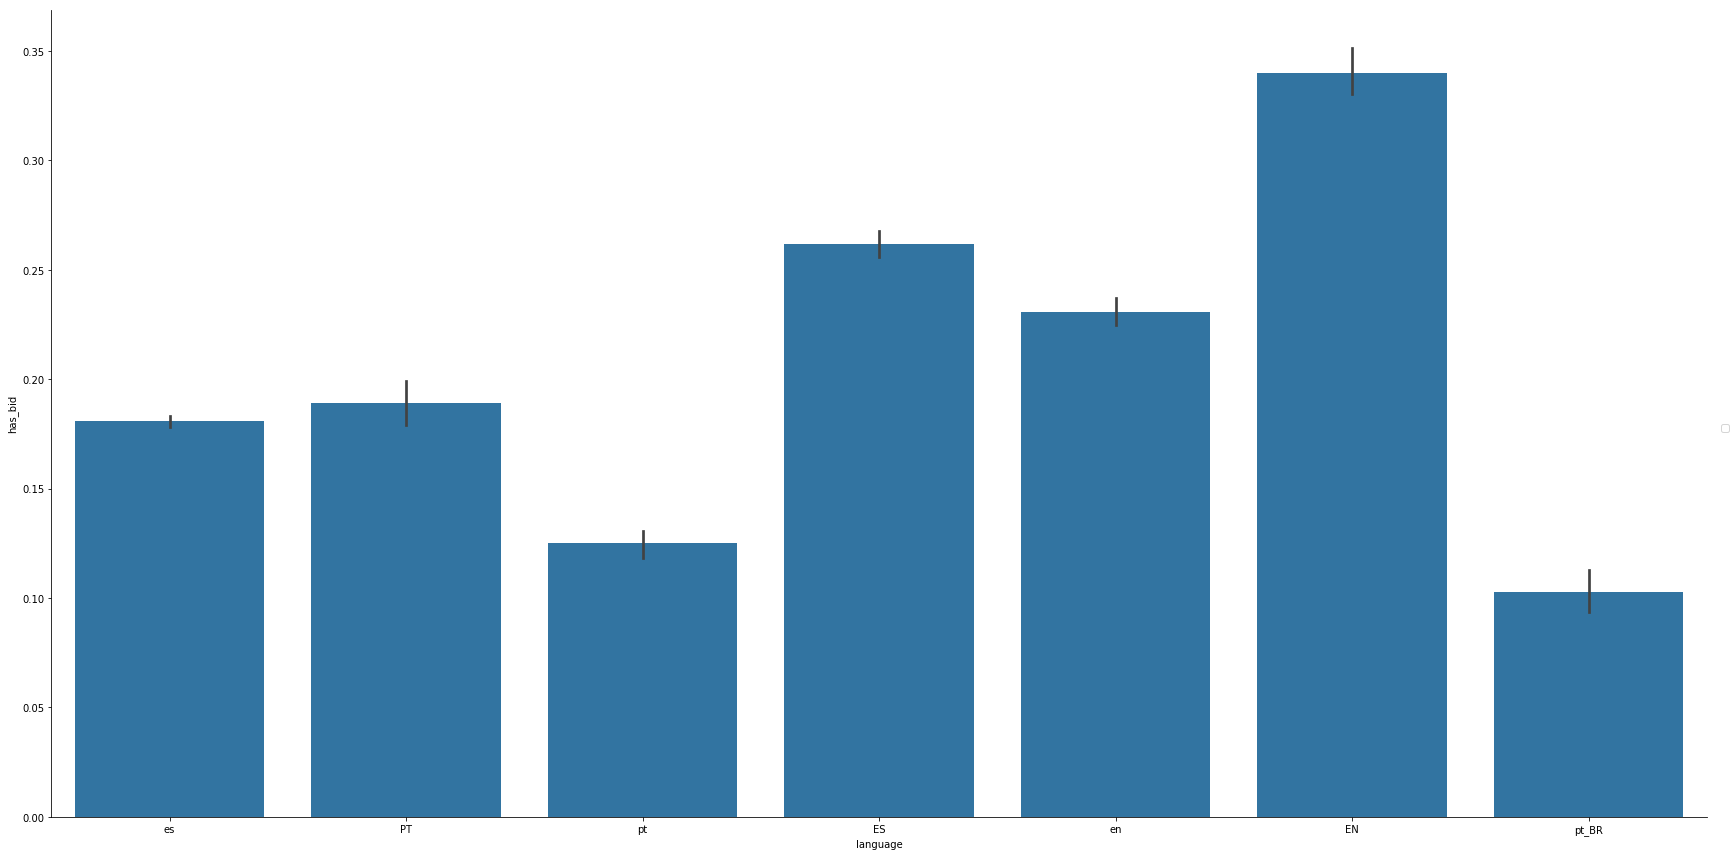

In [22]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [23]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139454 entries, 0 to 139453
Data columns (total 26 columns):
event_time          139454 non-null object
partner_id          139454 non-null int64
origin              139454 non-null object
destination         139454 non-null object
flight_number       139454 non-null float32
departure_date      139454 non-null object
departure_time      139454 non-null object
currency            139454 non-null object
language            139454 non-null object
pax                 139454 non-null float32
eligibility         139454 non-null bool
point_of_sale       139454 non-null object
channel_source      139454 non-null object
carrier_code        139454 non-null object
fare_class          139454 non-null object
from_cabin          139454 non-null object
upgrade_type        139454 non-null object
duration            139454 non-null float32
distance            139454 non-null float32
equipment           139454 non-null object
slider_max_usd      139454 n

### Prepare dataset

In [25]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
leOrigin = preprocessing.LabelEncoder()
leDestination = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    leDestination.fit(train_df_fact["destination"])
    train_df_fact["destination"] = leDestination.transform(train_df_fact["destination"])
    leOrigin.fit(train_df_fact["origin"])
    train_df_fact["origin"] = leOrigin.transform(train_df_fact["origin"])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [26]:
#factorize the categorical fields
columns_cat = ["equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [27]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139454 entries, 0 to 139453
Data columns (total 26 columns):
event_time          139454 non-null object
partner_id          139454 non-null int64
origin              139454 non-null int64
destination         139454 non-null int64
flight_number       139454 non-null int64
departure_date      139454 non-null object
departure_time      139454 non-null int64
currency            139454 non-null int64
language            139454 non-null int64
pax                 139454 non-null float32
eligibility         139454 non-null bool
point_of_sale       139454 non-null int64
channel_source      139454 non-null int64
carrier_code        139454 non-null int64
fare_class          139454 non-null int64
from_cabin          139454 non-null int64
upgrade_type        139454 non-null int64
duration            139454 non-null float32
distance            139454 non-null float32
equipment           139454 non-null int64
slider_max_usd      139454 non-null float3

## Create a model and evaluation

In [28]:
#Function utils
from sklearn.linear_model import LogisticRegression

random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


In [29]:
origins = train_df_fact.origin.unique()
destinations = train_df_fact.destination.unique()

def getTestDatasetsByRoute(testDatasetsX, testDatasetsY):
    datasetsByRouteX = []
    datasetsByRouteY = []
    origins_labels = []
    destinations_labels = []
    for i in origins:
        for j in destinations:
            idx = (testDatasetsX['origin'] == i) & (testDatasetsX['destination'] == j)
            datasetsByRouteX.append(testDatasetsX.loc[idx].copy())
            datasetsByRouteY.append(testDatasetsY.loc[idx].copy())
            origins_labels.append(i)
            destinations_labels.append(j)
    return datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels
    

def do_train_and_validate_by_route(df_to_train, n_splits = 2):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    X_train, X_valid, y_train, y_valid = train_test_split(x,y, test_size=0.30, random_state=42)
    random_forest.fit(X_train, y_train)
    datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels = getTestDatasetsByRoute(X_valid, y_valid)
    results = []
    for idx, val in enumerate(datasetsByRouteX):
        if (datasetsByRouteX[idx].shape[0] > 500):
            Y_test_pred = random_forest.predict_proba(datasetsByRouteX[idx])[:,1]
            fpr, tpr, _ = metrics.roc_curve(datasetsByRouteY[idx].astype(int), Y_test_pred)
            results.append([metrics.auc(fpr, tpr), leOrigin.inverse_transform(origins_labels[idx]), leDestination.inverse_transform(destinations_labels[idx])])
    results.sort(key=lambda x: x[0], reverse = True)
    for result in results:
        print("AUC = {}, ORIGIN = {}, DESTINATION = {}".format(result[0], result[1], result[2]))



### Feature engineering

In [30]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = train_df2.copy()

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


In [31]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139454 entries, 0 to 139453
Data columns (total 28 columns):
event_time               139454 non-null object
partner_id               139454 non-null int64
origin                   139454 non-null int64
destination              139454 non-null int64
flight_number            139454 non-null int64
departure_date           139454 non-null object
departure_time           139454 non-null int64
currency                 139454 non-null int64
language                 139454 non-null int64
pax                      139454 non-null float32
eligibility              139454 non-null bool
point_of_sale            139454 non-null int64
channel_source           139454 non-null int64
carrier_code             139454 non-null int64
fare_class               139454 non-null int64
from_cabin               139454 non-null int64
upgrade_type             139454 non-null int64
duration                 139454 non-null float32
distance                 139454 non-nu

In [32]:
train_df_3 = train_df_fact2.drop(["partner_id","eligibility", "departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "customer_id", "offer_amount"], axis=1)

In [ ]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139454 entries, 0 to 139453
Data columns (total 18 columns):
origin                   139454 non-null int64
destination              139454 non-null int64
flight_number            139454 non-null int64
departure_time           139454 non-null int64
currency                 139454 non-null int64
pax                      139454 non-null float32
channel_source           139454 non-null int64
carrier_code             139454 non-null int64
fare_class               139454 non-null int64
duration                 139454 non-null float32
distance                 139454 non-null float32
equipment                139454 non-null int64
slider_max_usd           139454 non-null float32
slider_min_usd           139454 non-null float32
slider_start_usd         139454 non-null float32
has_bid                  139454 non-null bool
days_before_departure    139454 non-null int64
destination_origin       139454 non-null int64
dtypes: bool(1), float32(6), int

In [ ]:
do_train_and_validate_by_route(train_df_3)